In [3]:
# Install the required libraries
!pip install opendatasets --upgrade --quiet
!pip install kaggle --quiet

# Import Kaggle and OpenDatasets to download datasets from Kaggle
import opendatasets as od

# Download the dataset from Kaggle
dataset_url = 'https://www.kaggle.com/datasets/abdulhasibuddin/uc-merced-land-use-dataset'
od.download(dataset_url)

import os
import random
import cv2
import numpy as np
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from keras.models import Model
import tensorflow as tf

# Set the path to the image folder
data_path = 'uc-merced-land-use-dataset/UCMerced_LandUse/Images'

# Initialize image data and labels
image_data = []
labels = []

# Load the image dataset
for root, dirs, files in os.walk(data_path):
    for file in files:
        if file.endswith(".tif"):
            # Read the image
            image = cv2.imread(os.path.join(root, file))
            image = cv2.resize(image, (128, 128))
            image = img_to_array(image)
            image_data.append(image)

            # Use the folder name as the label
            label = root.split(os.path.sep)[-1]
            labels.append(label)

# Convert to numpy arrays and normalize the images
image_data = np.array(image_data, dtype="float") / 255.0
labels = np.array(labels)

# Binarize the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(image_data, labels, test_size=0.2, random_state=42)

print(f'Training samples: {len(x_train)}, Testing samples: {len(x_test)}')

# Define the teacher model (more layers)
def teacher_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

# Define the student model (fewer layers)
def student_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

input_shape = (128, 128, 3)
num_classes = len(lb.classes_)

# Build teacher and student models
teacher = teacher_model(input_shape, num_classes)
student = student_model(input_shape, num_classes)

# Define a learning rate scheduler function
# def lr_scheduler(epoch, lr):
#     return lr * tf.math.exp(-0.1) if epoch >= 10 else lr

def lr_scheduler(epoch, lr):
    return float(lr * tf.math.exp(-0.1)) if epoch >= 10 else float(lr)

# Compile and train the teacher model
teacher.compile(optimizer=SGD(learning_rate=1e-2, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
teacher.fit(x_train, y_train, batch_size=32, epochs=15, validation_data=(x_test, y_test), callbacks=[LearningRateScheduler(lr_scheduler)])

# Precompute teacher's predictions for distillation
teacher_preds = teacher.predict(x_train)

# Define distillation loss function
def distillation_loss(y_true, y_pred, teacher_preds, temperature=3.0, alpha=0.1):
    teacher_batch_preds = tf.gather(teacher_preds, tf.range(tf.shape(y_pred)[0]))
    y_true = tf.keras.activations.softmax(y_true / temperature)
    y_pred = tf.keras.activations.softmax(y_pred / temperature)
    teacher_batch_preds = tf.keras.activations.softmax(teacher_batch_preds / temperature)
    soft_loss = tf.keras.losses.categorical_crossentropy(teacher_batch_preds, y_pred)
    hard_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    return alpha * soft_loss + (1. - alpha) * hard_loss

# Compile and train the student model using distillation loss
student.compile(optimizer=SGD(learning_rate=1e-2, momentum=0.9), loss=lambda y_true, y_pred: distillation_loss(y_true, y_pred, teacher_preds), metrics=['accuracy'])
student.fit(x_train, y_train, batch_size=32, epochs=30, validation_data=(x_test, y_test), callbacks=[LearningRateScheduler(lr_scheduler)])

# Evaluate models
teacher_score = teacher.evaluate(x_test, y_test, verbose=0)
student_score = student.evaluate(x_test, y_test, verbose=0)
print(f'Teacher test accuracy: {teacher_score[1] * 100:.2f}%')
print(f'Student test accuracy: {student_score[1] * 100:.2f}%')


Skipping, found downloaded files in "./uc-merced-land-use-dataset" (use force=True to force download)
Training samples: 1680, Testing samples: 420
Epoch 1/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 267s 5s/step - accuracy: 0.0315 - loss: 3.0411 - val_accuracy: 0.0405 - val_loss: 3.0174 - learning_rate: 0.0100
Epoch 2/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 262s 5s/step - accuracy: 0.0637 - loss: 2.9618 - val_accuracy: 0.1690 - val_loss: 2.8602 - learning_rate: 0.0100
Epoch 3/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 323s 5s/step - accuracy: 0.1397 - loss: 2.8115 - val_accuracy: 0.0619 - val_loss: 2.9714 - learning_rate: 0.0100
Epoch 4/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 320s 5s/step - accuracy: 0.1627 - loss: 2.7629 - val_accuracy: 0.2310 - val_loss: 2.4045 - learning_rate: 0.0100
Epoch 5/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 258s 5s/step - accuracy: 0.2841 - loss: 2.2773 - val_accuracy: 0.2310 - val_loss: 2.3965 - learning_rate: 0.0100
Epoch 6/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 260s 5s/step - accuracy: 0.2765 - loss: 2.3209 - val_accurac

In [4]:
# Define distillation loss function
def distillation_loss(y_true, y_pred, teacher_preds, temperature=3.0, alpha=0.1):
    teacher_batch_preds = tf.gather(teacher_preds, tf.range(tf.shape(y_pred)[0]))
    y_true = tf.keras.activations.softmax(y_true / temperature)
    y_pred = tf.keras.activations.softmax(y_pred / temperature)
    teacher_batch_preds = tf.keras.activations.softmax(teacher_batch_preds / temperature)
    soft_loss = tf.keras.losses.categorical_crossentropy(teacher_batch_preds, y_pred)
    hard_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    return alpha * soft_loss + (1. - alpha) * hard_loss

# Compile and train the student model using distillation loss
student.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=lambda y_true, y_pred: distillation_loss(y_true, y_pred, teacher_preds), metrics=['accuracy'])
student.fit(x_train, y_train, batch_size=32, epochs=15, validation_data=(x_test, y_test), callbacks=[LearningRateScheduler(lr_scheduler)])

# Evaluate models
teacher_score = teacher.evaluate(x_test, y_test, verbose=0)
student_score = student.evaluate(x_test, y_test, verbose=0)
print(f'Teacher test accuracy: {teacher_score[1] * 100:.2f}%')
print(f'Student test accuracy: {student_score[1] * 100:.2f}%')


Epoch 1/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.0607 - loss: 3.0445 - val_accuracy: 0.0357 - val_loss: 3.0445 - learning_rate: 0.0010
Epoch 2/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.0802 - loss: 3.0445 - val_accuracy: 0.1167 - val_loss: 3.0444 - learning_rate: 0.0010
Epoch 3/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.1127 - loss: 3.0445 - val_accuracy: 0.1571 - val_loss: 3.0444 - learning_rate: 0.0010
Epoch 4/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.1949 - loss: 3.0444 - val_accuracy: 0.2119 - val_loss: 3.0443 - learning_rate: 0.0010
Epoch 5/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.2462 - loss: 3.0443 - val_accuracy: 0.2548 - val_loss: 3.0442 - learning_rate: 0.0010
Epoch 6/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.3450 - loss: 3.0440 - val_accuracy: 0.3833 - val_loss: 3.0440 - learning_rate: 0.0010
Epoch 7/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.4561 - loss: 3.0438 - val_accuracy: 

In [5]:
# # Define distillation loss function
# def distillation_loss(y_true, y_pred, teacher_preds, temperature=3.0, alpha=0.1):
#     teacher_batch_preds = tf.gather(teacher_preds, tf.range(tf.shape(y_pred)[0]))
#     y_true = tf.keras.activations.softmax(y_true / temperature)
#     y_pred = tf.keras.activations.softmax(y_pred / temperature)
#     teacher_batch_preds = tf.keras.activations.softmax(teacher_batch_preds / temperature)
#     soft_loss = tf.keras.losses.categorical_crossentropy(teacher_batch_preds, y_pred)
#     hard_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
#     return alpha * soft_loss + (1. - alpha) * hard_loss

# # Compile and train the student model using distillation loss
# student.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=lambda y_true, y_pred: distillation_loss(y_true, y_pred, teacher_preds), metrics=['accuracy'])
# student.fit(x_train, y_train, batch_size=32, epochs=30, validation_data=(x_test, y_test), callbacks=[LearningRateScheduler(lr_scheduler)])

# # Evaluate models
# teacher_score = teacher.evaluate(x_test, y_test, verbose=0)
# student_score = student.evaluate(x_test, y_test, verbose=0)
# print(f'Teacher test accuracy: {teacher_score[1] * 100:.2f}%')
# print(f'Student test accuracy: {student_score[1] * 100:.2f}%')


Epoch 1/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.9028 - loss: 3.0424 - val_accuracy: 0.6095 - val_loss: 3.0435 - learning_rate: 0.0010
Epoch 2/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.9166 - loss: 3.0424 - val_accuracy: 0.5857 - val_loss: 3.0436 - learning_rate: 0.0010
Epoch 3/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9170 - loss: 3.0423 - val_accuracy: 0.6095 - val_loss: 3.0434 - learning_rate: 0.0010
Epoch 4/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9311 - loss: 3.0423 - val_accuracy: 0.6119 - val_loss: 3.0435 - learning_rate: 0.0010
Epoch 5/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.9371 - loss: 3.0423 - val_accuracy: 0.5810 - val_loss: 3.0436 - learning_rate: 0.0010
Epoch 6/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9332 - loss: 3.0423 - val_accuracy: 0.5833 - val_loss: 3.0435 - learning_rate: 0.0010
Epoch 7/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.9557 - loss: 3.0422 - val_accuracy: 

KeyboardInterrupt: 

In [6]:
# Evaluate and print additional metrics for teacher and student models
from sklearn.metrics import classification_report
import time

def evaluate_model(model, x_test, y_test):
    # Predict the labels
    start_time = time.time()
    y_pred_probs = model.predict(x_test)
    inference_time = time.time() - start_time

    # Get the predicted classes
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Calculate precision, recall, F1 score
    report = classification_report(y_true, y_pred, target_names=lb.classes_)

    # Print the metrics
    print(report)
    print(f"Inference Time: {inference_time:.4f} seconds")
    return y_pred_probs

print("=== Teacher Model Evaluation ===")
teacher_pred_probs = evaluate_model(teacher, x_test, y_test)

print("\n=== Student Model Evaluation ===")
student_pred_probs = evaluate_model(student, x_test, y_test)

=== Teacher Model Evaluation ===
14/14 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step
                   precision    recall  f1-score   support

     agricultural       0.81      0.96      0.88        23
         airplane       0.53      0.40      0.46        20
  baseballdiamond       0.68      0.68      0.68        22
            beach       1.00      1.00      1.00        18
        buildings       0.30      0.18      0.22        17
        chaparral       0.93      1.00      0.97        14
 denseresidential       0.40      0.78      0.53        18
           forest       0.93      0.78      0.85        18
          freeway       0.75      0.57      0.65        21
       golfcourse       0.70      0.62      0.65        26
           harbor       0.85      0.96      0.90        24
     intersection       0.82      0.50      0.62        18
mediumresidential       0.40      0.37      0.38        27
   mobilehomepark       0.67      0.71      0.69        17
         overpass       0.44      0.47    

14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 292ms/step
Alpha: 0.01 - F1 Score: 0.6033, Accuracy: 0.6095
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 277ms/step
Alpha: 0.1 - F1 Score: 0.5990, Accuracy: 0.6071
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 278ms/step
Alpha: 0.2 - F1 Score: 0.5816, Accuracy: 0.5810
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 280ms/step
Alpha: 0.3 - F1 Score: 0.6147, Accuracy: 0.6071
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 285ms/step
Alpha: 0.4 - F1 Score: 0.5975, Accuracy: 0.5833


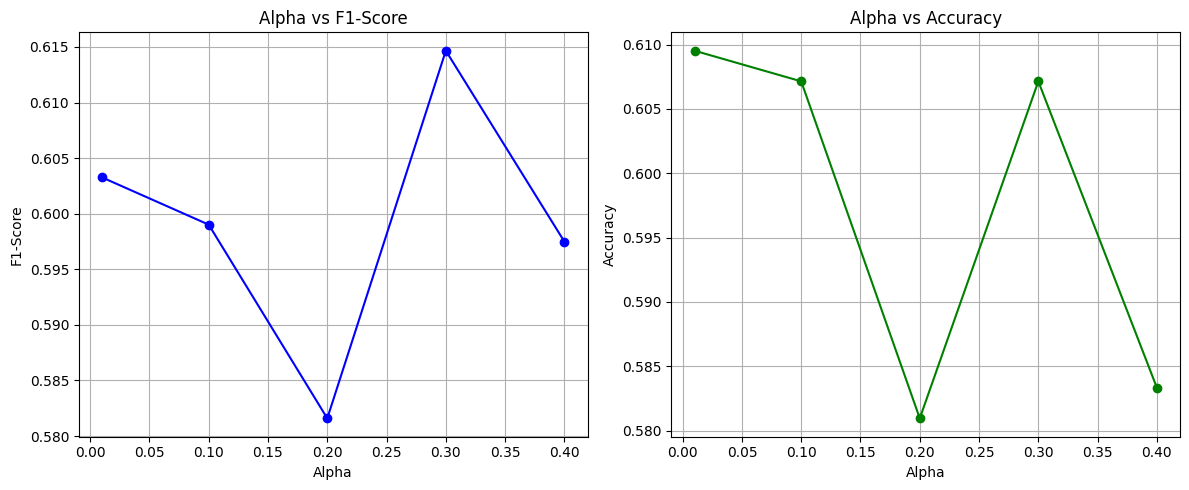

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score

# Define alpha values for experiments
alpha_values = [0.01, 0.1, 0.2, 0.3, 0.4]
f1_scores = []
accuracies = []

# Function to evaluate F1-score and accuracy for a given model and alpha
def evaluate_student_with_alpha(alpha):
    # Redefine distillation loss function with current alpha
    def distillation_loss(y_true, y_pred, teacher_preds, temperature=3.0, alpha=alpha):
        teacher_batch_preds = tf.gather(teacher_preds, tf.range(tf.shape(y_pred)[0]))
        y_true = tf.keras.activations.softmax(y_true / temperature)
        y_pred = tf.keras.activations.softmax(y_pred / temperature)
        teacher_batch_preds = tf.keras.activations.softmax(teacher_batch_preds / temperature)
        soft_loss = tf.keras.losses.categorical_crossentropy(teacher_batch_preds, y_pred)
        hard_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
        return alpha * soft_loss + (1. - alpha) * hard_loss

    # Compile the student model with the new distillation loss
    student.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                    loss=lambda y_true, y_pred: distillation_loss(y_true, y_pred, teacher_preds),
                    metrics=['accuracy'])

    # Train the student model
    student.fit(x_train, y_train, batch_size=32, epochs=15, validation_data=(x_test, y_test),
                callbacks=[LearningRateScheduler(lr_scheduler)], verbose=0)

    # Predict and evaluate
    y_pred_probs = student.predict(x_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Calculate and store F1-score and accuracy
    f1 = f1_score(y_true, y_pred, average='weighted')
    acc = accuracy_score(y_true, y_pred)
    f1_scores.append(f1)
    accuracies.append(acc)
    print(f"Alpha: {alpha} - F1 Score: {f1:.4f}, Accuracy: {acc:.4f}")

# Run evaluation for each alpha
for alpha in alpha_values:
    evaluate_student_with_alpha(alpha)

# Plot F1-Score vs. Alpha
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(alpha_values, f1_scores, marker='o', color='b')
plt.title("Alpha vs F1-Score")
plt.xlabel("Alpha")
plt.ylabel("F1-Score")
plt.grid(True)

# Plot Accuracy vs. Alpha
plt.subplot(1, 2, 2)
plt.plot(alpha_values, accuracies, marker='o', color='g')
plt.title("Alpha vs Accuracy")
plt.xlabel("Alpha")
plt.ylabel("Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()